In [2]:
import pandas as pd

# load text data
with open('training_text', 'r') as training_text_file:
    training_text = training_text_file.read().split('\n')

training_text_header = training_text[0].split(',')
training_text_data = map(lambda row: row.split('||'), training_text[1:-1])
training_text_df = pd.DataFrame(training_text_data, columns=training_text_header)
training_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null object
Text    3321 non-null object
dtypes: object(2)
memory usage: 52.0+ KB


In [3]:
# load variants data
with open('training_variants', 'r') as training_variants_file:
    training_variants = training_variants_file.read().split('\n')

training_variants_header = training_variants[0].split(',')
training_variants_data = map(lambda row: row.split(','), training_variants[1:-1])
training_variants_df = pd.DataFrame(training_variants_data, columns=training_variants_header)
training_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null object
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null object
dtypes: object(4)
memory usage: 103.9+ KB


In [4]:
# merge training data based on ID field
training = pd.merge(training_variants_df, training_text_df)
training.head(n=3)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...


In [5]:
# view labels support
training_labels_support_df = pd.DataFrame(training['Class'].value_counts()).rename(
    {'Class':'label_support'}, axis=1
)
training_labels_support_df['label_support_percentage'] = \
    training_labels_support_df['label_support'] / training.shape[0]
training_labels_support_df = training_labels_support_df.reset_index().rename({'index':'class'}, axis=1)
training_labels_support_df['class'] = training_labels_support_df['class'].astype('int')
training_labels_support_df

,class,label_support,label_support_percentage
0,7,953,0.286962
1,4,686,0.206564
2,1,568,0.171033
3,2,452,0.136104
4,6,275,0.082806
5,5,242,0.072870
6,3,89,0.026799
7,9,37,0.011141
8,8,19,0.005721


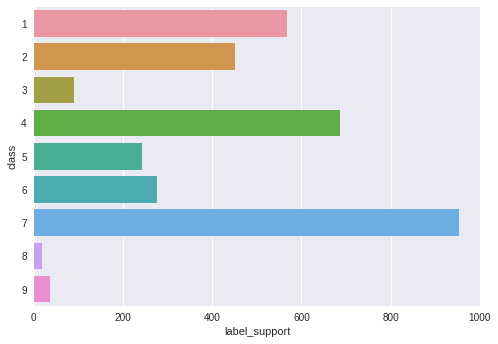

In [6]:
# visualizing labels support
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

sns.barplot(x='label_support', y='class', data=training_labels_support_df, orient='h')
plt.show()

Data is imbalanced, there are 9 classes, 3321 samples, no missed values
#### ------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# correlation analog for categorial variables
# needed to be refactored
import numpy as np
import itertools
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

columns_for_cramers_v = ['Gene', 'Variation', 'Class']
len_columns_for_cramers_v = len(columns_for_cramers_v)
corr_matrix = np.zeros((len_columns_for_cramers_v, len_columns_for_cramers_v))
for col1, col2 in itertools.combinations(columns_for_cramers_v, 2):
    idx1, idx2 = columns_for_cramers_v.index(col1), columns_for_cramers_v.index(col2)
    corr_matrix[idx1, idx2] = cramers_corrected_stat(pd.crosstab(training[col1], training[col2]))
    corr_matrix[idx2, idx1] = corr_matrix[idx1, idx2]

corr = pd.DataFrame(corr_matrix, index=columns_for_cramers_v, columns=columns_for_cramers_v)

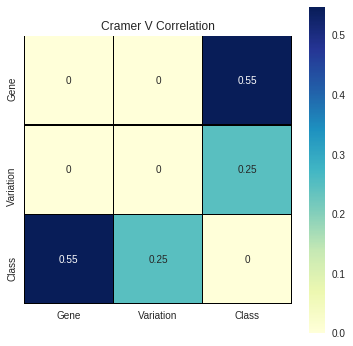

In [8]:
# plot heatmap of Cramer's statistic
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    corr, ax=ax, linewidths=0.25, square=True, annot=True,
    cmap="YlGnBu", linecolor='black'
)
ax.set_title("Cramer V Correlation")
plt.show()

We can not say that Gene and Variation columns are associated to each other, while both of them impact the Class, which is target
#### ------------------------------------------------------------------------------------------------------------------------------------------------
The next and, probably, the main step is text preprocessing, consist of several points, which are:
- transform text in lowercase
- removing numbers
- remove punctuation
- remove whitespaces
- tokenization
- removing stop words
- stemming
- lemmatization

In [9]:
import re
import string

# copy original dataset
training_copy = training.copy()
# rename original columns into lower
training_copy.columns = [column.lower() for column in training_copy.columns]
# print example before few steps
print('Before first preprocessing\n{}'.format(training_copy['text'].values[0][:50]))
# lowercase
training_copy['text'] = training_copy['text'].apply(lambda row: row.lower())
# removing numbers
training_copy['text'] = training_copy['text'].apply(lambda row: re.sub(r'\d+', '', row))
# removing punctuation
punctuation_translation_table = str.maketrans(
    {symbol:'' for symbol in string.punctuation}
)
training_copy['text'] = training_copy['text'].apply(
    lambda row: row.translate(punctuation_translation_table)
)
# removing whitespaces
training_copy['text'] = training_copy['text'].apply(lambda row: row.strip())
# print example after few steps
print('\nAfter removing specific symbols\n{}'.format(training_copy['text'].values[0][:50]))

Before first preprocessing
Cyclin-dependent kinases (CDKs) regulate a variety

After removing specific symbols
cyclindependent kinases cdks regulate a variety of


In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenization
training_copy['text'] = training_copy['text'].apply(lambda row: word_tokenize(row))
# removing stop words
stop_words = set(stopwords.words('english'))
training_copy['text'] = training_copy['text'].apply(
    lambda list_of_words:
    [word for word in list_of_words if not word in stop_words]
)
# print example after few steps
print('After removing stop words\n{}'.format(training_copy['text'].values[0][:5]))

[nltk_data] Downloading package punkt to /home/pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


After removing stop words
['cyclindependent', 'kinases', 'cdks', 'regulate', 'variety']


In [11]:
from nltk.stem import PorterStemmer

# stemming
stemmer = PorterStemmer()
training_copy['text'] = training_copy['text'].apply(
    lambda list_of_words: [stemmer.stem(word) for word in list_of_words]
)
# print example after few steps
print('After stemming\n{}'.format(training_copy['text'].values[0][:5]))

After stemming
['cyclindepend', 'kinas', 'cdk', 'regul', 'varieti']


In [12]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# lemmatization
lemmatizer = WordNetLemmatizer()
training_copy['text'] = training_copy['text'].apply(
    lambda list_of_words: [lemmatizer.lemmatize(word) for word in list_of_words]
)
# print example after few steps
print('After lemmatization\n{}'.format(training_copy['text'].values[0][:5]))

[nltk_data] Downloading package wordnet to /home/pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


After lemmatization
['cyclindepend', 'kina', 'cdk', 'regul', 'varieti']


In [13]:
# helper function to generate vocabulary from the whole corpus 
def tokenize(list_of_words):
    words = []
    for word in list_of_words:
        words.extend(word)
        words = list(set(words))
        
    words = sorted(list(set(words)))
    return words

vocab = tokenize(training_copy['text'].values)
# number of tokens
print(
    'Overall number of tokens: {}'.format(len(vocab))
)

Overall number of tokens: 137214


In [14]:
# function to generate bag of words representations
def generate_bow(list_of_words, vocab):
    bag_vector = np.zeros(len(vocab))
    for word in list_of_words:
        for idx, token in enumerate(vocab):
            if token == word: 
                bag_vector[idx] += 1
    return bag_vector

training_copy['text'] = training_copy['text'].apply(
    lambda list_of_words: generate_bow(list_of_words, vocab)
)